In [45]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, random_split
from torchvision import transforms
from board_detection import homography_dataset
from board_detection.homomography_network import HomographyNet
from board_detection.homomography_training import show_perspective_corrected_board
from board_detection.homomography_training import load_dataset
from board_detection.homomography_training import train_model
from board_detection.homomography_training import calculate_test_loss
from board_detection.homography_loss import PhotometricLoss

In [48]:
input_transform_pipeline = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.Grayscale(num_output_channels=1),  # Convert to grayscale
    transforms.ToTensor()
])

label_transform_pipeline = transforms.Compose([
    homography_dataset.HomographyOutputTransform((512, 512), (256, 256)),
    transforms.Lambda(lambda x: torch.tensor(x, dtype=torch.float32)), 
    transforms.Lambda(lambda x: torch.flatten(x))
])

json_path = "pre_processing/data/output/perspective_distorted_boards/bbox_coordinates.json"
img_dir = "pre_processing/data/output/perspective_distorted_boards"

dataset = load_dataset(json_path, img_dir, input_transform_pipeline, label_transform_pipeline)
train_size = int(0.7 * len(dataset))
val_size = int(0.15 * len(dataset))
test_size = len(dataset) - train_size - val_size


train_dataset, val_dataset, test_dataset = random_split(dataset, [train_size, val_size, test_size])
batch_size = 8
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

learning_rate = 0.001
num_epochs = 105
model = HomographyNet((1, 256, 256), 9) # cuz the matrix is flat 3 x 3
# criterion = nn.MSELoss()
criterion = PhotometricLoss(model)
device = "cuda"
optimizer = optim.Adam(model.parameters(), lr=learning_rate)
save_path = "runs/models/homomography_hybrid_256_model.pth"
# save_path = None
resume_path =  "runs/models/homomography_hybrid_256_model.pth"
# resume_path = None


train_losses, val_losses, best_model_state_dict = train_model(model, train_loader, val_loader, criterion, optimizer, num_epochs, device, save_path, resume_path)
model.eval()
test_loss = calculate_test_loss(model, test_loader, criterion, device)

Epoch 1/105:  12%|█▏        | 101/875 [00:30<03:54,  3.30it/s, avg_loss=544.7852, loss=236.3253]


KeyboardInterrupt: 

In [3]:
model.load_state_dict(best_model_state_dict)

<All keys matched successfully>

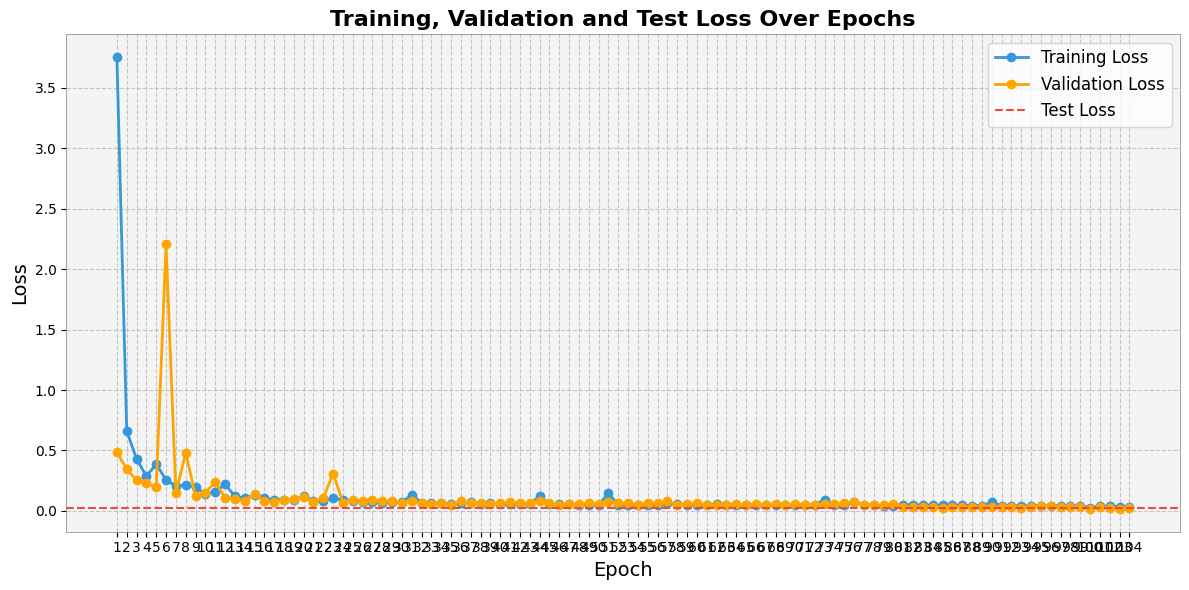

In [4]:
from visualization import show_loss 
show_loss.show_train_test_loss(train_losses, val_losses, test_loss, num_epochs - 1 )

[[ 0.9282436   0.11539263 -5.9115653 ]
 [-0.09681179  1.1346091  -2.9458807 ]
 [ 0.          0.          1.        ]]
[[ 9.1619581e-01  1.2364864e-01 -5.6710658e+00]
 [-1.0160719e-01  1.1475840e+00 -2.9425240e+00]
 [ 8.8520347e-10 -1.8750852e-09  1.0000000e+00]]


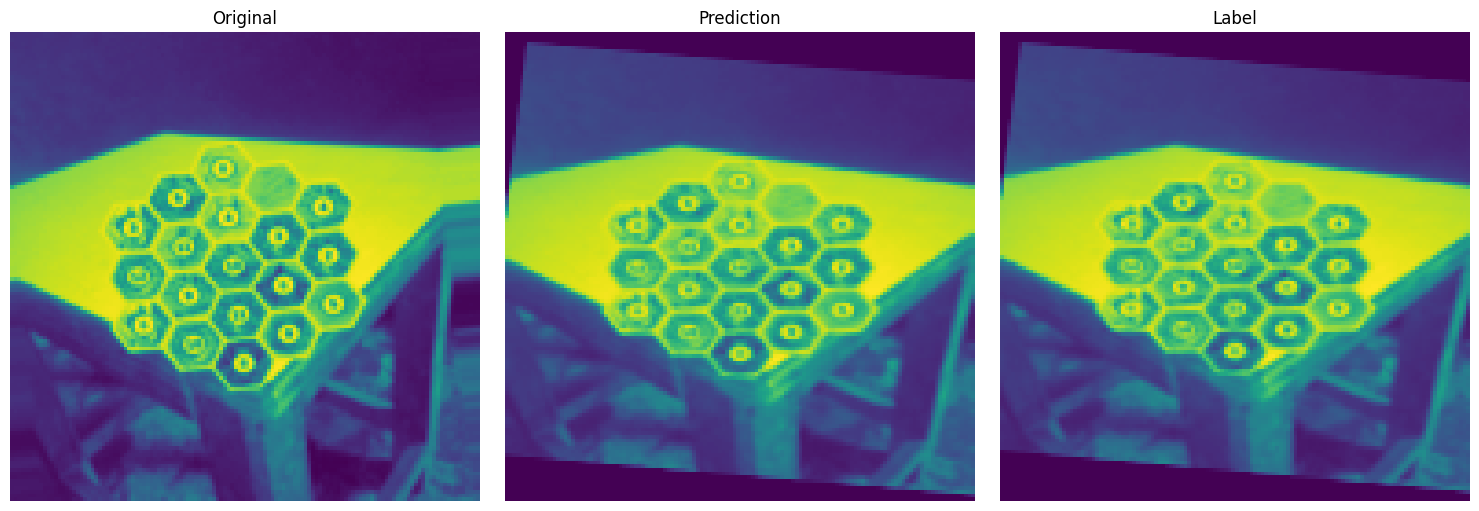

array([[0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       ...,
       [0.        , 0.        , 0.        , ..., 0.3985294 , 0.38278952,
        0.36516544],
       [0.        , 0.        , 0.        , ..., 0.05202206, 0.08621324,
        0.11485141],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ]], dtype=float32)

In [44]:
from visualization import utils
import cv2


image, label = dataset.__getitem__(np.random.randint(0, dataset.__len__()))
image = image.to(device)  # Move the image to the same device as the model
matrix = model(image.unsqueeze(0))
# matrix = model(image.unsqueeze(0))




# label, matrix = label.detach().numpy().reshape(3, 3), 
# print(label.detach().numpy().reshape(3, 3))
# print(matrix.detach().numpy().reshape(3, 3))
show_perspective_corrected_board(model, image, label)

In [6]:
from ultralytics import YOLO
from board_detection.yolo_extraction import board_detection_step


data_dir = "data/sample/perspective_distorted_boards_sample/images"
model_path = "board_detection/data/input/runs/train10/weights/best.pt"  # Replace with your trained model
class_id_to_find = 0  # Change this to the class ID of the object you want to search for

model_yolo = YOLO(model_path)
# Run detection & plot results
board_detection_step("data/full/perspective_distorted_boards/train/images/canvas_image_0.png", model)

[ WARN:0@16.157] global loadsave.cpp:268 findDecoder imread_('data/full/perspective_distorted_boards/train/images/canvas_image_0.png'): can't open/read file: check file path/integrity


TypeError: conv2d() received an invalid combination of arguments - got (NoneType, Parameter, Parameter, tuple, tuple, tuple, int), but expected one of:
 * (Tensor input, Tensor weight, Tensor bias = None, tuple of ints stride = 1, tuple of ints padding = 0, tuple of ints dilation = 1, int groups = 1)
      didn't match because some of the arguments have invalid types: (!NoneType!, !Parameter!, !Parameter!, !tuple of (int, int)!, !tuple of (int, int)!, !tuple of (int, int)!, !int!)
 * (Tensor input, Tensor weight, Tensor bias = None, tuple of ints stride = 1, str padding = "valid", tuple of ints dilation = 1, int groups = 1)
      didn't match because some of the arguments have invalid types: (!NoneType!, !Parameter!, !Parameter!, !tuple of (int, int)!, !tuple of (int, int)!, !tuple of (int, int)!, !int!)
